###**ATOC4500 Data Science Lab: Application Lab #3: Intro to Machine Learning with Meteorological Station Data**
###last updated: February 27, 2022
**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

LEARNING GOALS:
1. Use k-means clustering as an example of unsupervised (grouping events into different categories) machine learning
2. Become familiar with the limits and applicability of K-means clustering to detect the seasons in Colorado
3. Assess sensitivity of K-means to standardization, changing the input data, and number of clusters.

In this lab, we will use [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to classify weather data into different clusters.  Each cluster might look like a season.  Why would we cluster weather observations?  We already know which observations are in which season by looking at the date. But we all know that in Colorado: *a day in February sometimes feels like summer and a day in September can feel like winter.*  We often have multiple seasons in a single week... So this could be quite fun to see how the algorithm decides how to cluster our data and assign each day to a "season". :) <br>

**STEP 1: Import packages and functions we will use**

In [ ]:
import pandas as pd
import numpy as np
import datetime
#import datetime as dt
from google.colab import files

from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

**STEP 2: Read in the Data and Look At It, Add a variable in the dataframe for the season**

In [ ]:
### upload file al3_christman_2016.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving al3_christman_2016.csv to al3_christman_2016 (1).csv
User uploaded file "al3_christman_2016.csv" with length 510492 bytes


In [ ]:
df = pd.read_csv("al3_christman_2016.csv")
## transform the day column into a readable date. Can only run once successfully.
df['day'] = [datetime.date.fromordinal(day+693594) for day in df['day']] 
#print(df['day'])
## preview data (also through df.head() & df.tail())
df

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches
0,2016-01-01,0.000000,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0.0
1,2016-01-01,0.041667,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0.0
2,2016-01-01,0.083333,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0.0
3,2016-01-01,0.125000,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0.0
4,2016-01-01,0.166667,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2016-12-31,0.791667,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0.0
8780,2016-12-31,0.833333,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0.0
8781,2016-12-31,0.875000,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0.0
8782,2016-12-31,0.916667,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0.0


In [ ]:
print(f'How many days are in this dataset? {df.day.nunique()}')

How many days are in this dataset? 366


In [ ]:
## add a new variable called "season" to the dataframe df
## this variable contains the season defined traditionally based on the month: 
## DJF=winter, MAM=spring, JJA=summer, SON=fall

## use a dictionary to define seasons from months
### define the seasons as DJF=winter=1, MAM=spring=2, JJA=summer=3, SON=fall=4

seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}
## define a function to assign seasons to months using the dictionary
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k]

## apply the function season to one time in my dataset as a sanity check
#print(df['day'][5000].month)
#print(season(df['day'][5000].month))

## apply it to all times in my dataset - check
#for month in pd.DatetimeIndex(df['day']).month[-5000:-4890]:
#  print(season(month))

## apply the function season to all times in my dataset
df['season']=[season(month) for month in pd.DatetimeIndex(df['day']).month]

#check random value values
#df['season'][5000]

## check the data frame to see if there is a new variable called "season"
df

,day,hour,temp_F,RH,dewtemp_F,wind_mph,wind_dir,windgust,windgust_dir,pres_Hg,SOLIN_Wm2,Prec_inches,season
0,2016-01-01,0.000000,7.0,72.2,-0.1,1.2,234,3.9,224,851.30,0.0,0.0,1
1,2016-01-01,0.041667,5.4,74.3,-1.0,3.4,299,7.1,302,850.82,0.0,0.0,1
2,2016-01-01,0.083333,6.4,73.8,-0.2,2.8,200,7.0,301,849.83,0.0,0.0,1
3,2016-01-01,0.125000,3.0,73.5,-3.6,2.9,309,6.1,349,850.69,0.0,0.0,1
4,2016-01-01,0.166667,3.7,76.9,-1.9,3.1,346,5.3,255,848.24,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2016-12-31,0.791667,22.3,74.3,15.4,0.9,221,3.3,202,833.32,0.0,0.0,1
8780,2016-12-31,0.833333,20.3,80.4,15.3,0.6,279,2.9,279,833.45,0.1,0.0,1
8781,2016-12-31,0.875000,19.9,81.1,15.1,0.5,197,2.5,279,833.01,0.1,0.0,1
8782,2016-12-31,0.916667,17.8,82.8,13.5,2.0,353,4.8,352,832.78,0.1,0.0,1


**STEP 3: Select Data To Use, Convert data into a Numpy Array, Look at data again!**

In [ ]:
#### select the time

##Only select noons, or when day_fraction is equal to 0.5.
noondf = df[df.hour==0.5] ## noon

### tinker later (code that you may want to "borrow" later in this notebook)
##noondf = df[hour==0.25] ## what time is this??
#noondf = df # try selecting all data instead of just noon data

In [ ]:
## Select variables of interest. Aside variables are called "features" by some in the ML world.

included_cols = ['temp_F','RH','dewtemp_F','wind_mph','windgust','pres_Hg','SOLIN_Wm2','Prec_inches'] # original input

### tinker later (code that you may want to "borrow" later in the lab)
# try removing insolation as a feature
#included_cols = ['temp_F','RH','dewtemp_F','wind_mph','windgust','pres_Hg','Prec_inches'] 
#included_cols = ['temp_F','wind_mph'] # try only using temp_F and wind_mph
#included_cols = ['RH','wind_mph'] # try only using RH and wind_mph

## convert to a numpy array for model input and leave out the time dimensions day & hour, and wind directions.
data = noondf.loc[:, noondf.columns.isin(list(included_cols))].to_numpy()

## check the shape of your data -- should be (366,8) (days, variable)
print(f'Your data are now 366 observations over 8 variables: {np.shape(data)}')

Your data are now 366 observations over 8 variables: (366, 8)


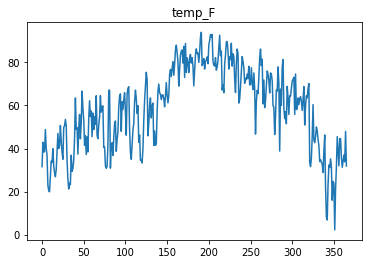

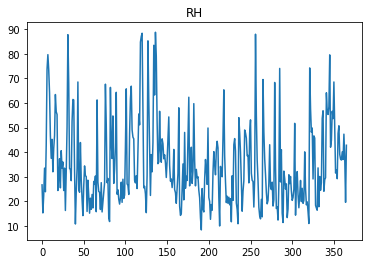

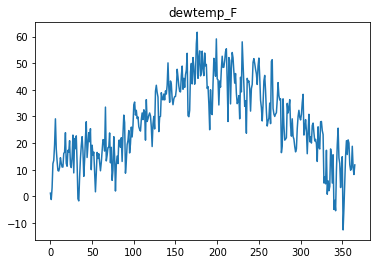

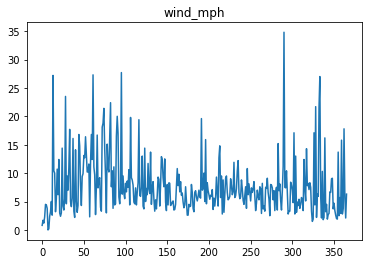

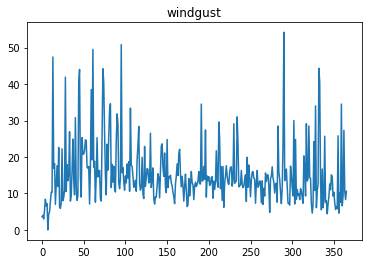

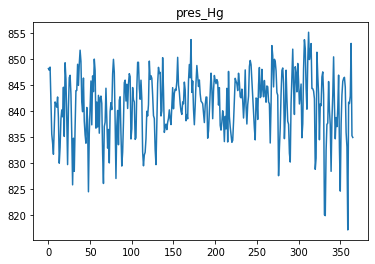

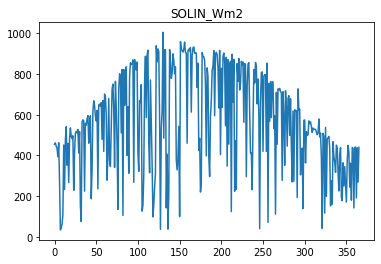

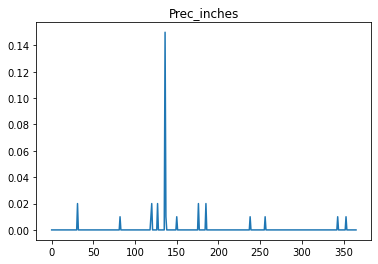

In [ ]:
### option to check out quick plots of your data...
### say yes first time through - double check your input, ALWAYS.
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(data)[1]):
    plt.plot(data[:,i]);
    plt.title(included_cols[i])
    plt.show()

**STEP 4: Recale your data to have unit variance, Look at your data again!**. *Why? Since clustering among features depends on distance, we need to scale all of our features so that all features have equal variance. We don't want the clustering to be dominated by the feature with the largest variance...*

In [ ]:
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.whiten.html
#"Before running k-means, it is beneficial to rescale each feature dimension of the observation 
#set by its standard deviation (i.e. “whiten” it - as in “white noise” where each frequency has equal power). 
#Each feature is divided by its standard deviation across all observations to give it unit variance."
scaled_data = whiten(data) # sci-kit learn's function to standardize data in the clustering toolbox
#scaled_data = data.copy() # uncomment to NOT whiten, but still enable this notebook to run without modifications

## Check that you end up with the same shape as the original data...
print(f'LOOK AT YOUR DATA: shape should be (days, variable), more specifically (366,8): {np.shape(scaled_data)}')

print('mean of each variable')
print(np.mean(scaled_data,axis=0))
print('standard deviation of each variable')
print(np.std(scaled_data,axis=0))

LOOK AT YOUR DATA: shape should be (days, variable), more specifically (366,8): (366, 8)
mean of each variable
[3.08126841e+00 2.07186702e+00 1.94726665e+00 1.54064165e+00
 1.82644739e+00 1.40370093e+02 2.31275140e+00 1.09089270e-01]
standard deviation of each variable
[1. 1. 1. 1. 1. 1. 1. 1.]


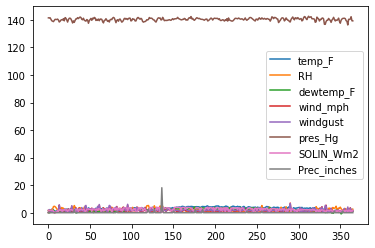

In [ ]:
## option to check out quick plots of your data... always take this option.
## note: we did not remove the mean...
quickplot = 'yes'
if quickplot == 'yes':
  ## Quick plots of your data
  for i in np.arange(0,np.shape(scaled_data)[1]):
    plt.plot(scaled_data[:,i],label=included_cols[i]);
    ## check what happens when you uncomment the two lines below
    #plt.title(included_cols[i])
    #plt.show()
  plt.legend()

**STEP 5: Use K-means clustering to look for patterns in the data**

In [ ]:
## select the number of clusters (i.e., here the number of seasons you want to try to identify using the weather data)
NO_CLUSTERS = 4 # try 2 for separating cold & warm seasons or 4 for separating into winter, fall, spring, summer

## do the clustering, return centroids (i.e., Coordinates of cluster centers.)
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)

**STEP 6: Visualize your results**.

In [ ]:
## find an index (idx) that is the label for each value in your dataset (i.e, each day at noon in 2016)
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html
idx, _ = vq(scaled_data,centroids) # vq returns cluster idx for each observation

## add 1 so that idx is also 1-based like df['season']
idx=idx+1

print('Here is the cluster idx for each day of the year:') 
print(idx) # prints K-mean's season label for each day in the year

Here is the cluster idx for each day of the year:
[1 1 1 1 1 1 3 3 3 3 3 1 3 2 1 3 3 3 3 1 1 1 1 3 2 1 1 1 2 1 3 3 3 2 1 1 3
 2 3 1 2 1 1 3 2 2 1 1 2 1 2 1 2 2 1 1 1 1 1 2 1 2 1 1 1 1 2 1 1 1 1 1 2 2
 2 2 3 1 2 1 2 2 2 1 1 1 1 1 1 2 2 2 1 1 4 2 1 4 1 4 1 3 4 4 4 3 2 3 1 1 1
 4 4 1 1 4 2 3 3 3 3 3 1 4 4 4 4 3 3 4 2 1 4 4 3 3 3 3 4 4 4 4 4 4 4 4 1 2
 1 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 1 4 3 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 3 4 4
 4 1 4 4 4 4 3 4 1 4 4 4 4 4 1 4 4 4 1 1 3 1 1 1 2 4 3 4 1 4 2 2 1 1 1 1 1
 1 1 1 4 4 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 3 3 1 3 1 2 1 2 1 1 3 2
 2 1 1 3 3 1 2 1 3 3 3 3 3 3 3 3 3 3 3 1 1 1 2 3 1 1 2 1 1 2 1 1 3]


['temp_F', 'RH', 'dewtemp_F', 'wind_mph', 'windgust', 'pres_Hg', 'SOLIN_Wm2', 'Prec_inches']
plotting these variables: ['temp_F', 'SOLIN_Wm2']
temp_F
SOLIN_Wm2


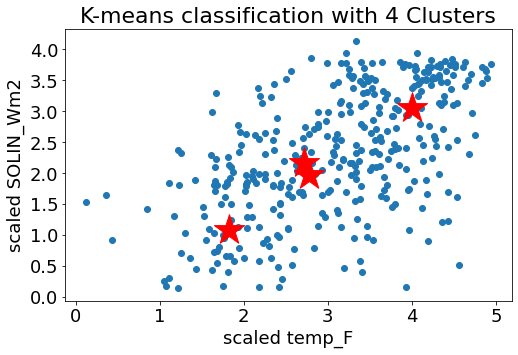

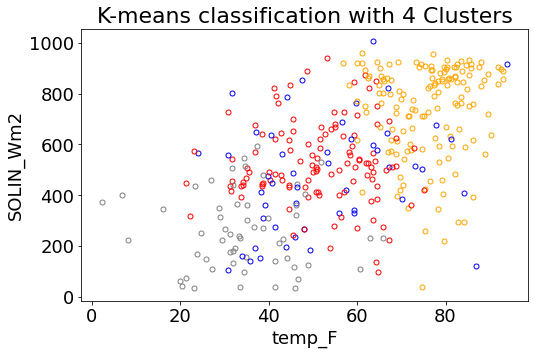

In [ ]:
## Create a few xy scatter plots, where points are colored by "season" (from clustering algorithm)
## and each k-means-determined centroid is in a red stars overlaid.

### Pick any two variables that are a part of included_cols
print(included_cols)
### select two variables and put them in vars2plot - # format (x, y)
vars2plot = ['temp_F','SOLIN_Wm2']
print(f'plotting these variables: {vars2plot}')

### other options (code to steal for later)
#vars2plot = ['RH','wind_mph']
#vars2plot = ['temp_F','pres_Hg'] # format (x, y)
#vars2plot = ['temp_F','wind_mph'] # format (x, y)
#vars2plot = ['wind_mph','windgust'] # format (x, y)

data2plot = [data[:,included_cols.index(var)] for var in vars2plot]

## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  print(vars2plot[i])
  varidx2plot[i]=included_cols.index(vars2plot[i])
#print(varidx2plot)

### Now plot these variables as scaled values with the cluster centers
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
plt.scatter(scaled_data[:, varidx2plot[0]], scaled_data[:, varidx2plot[1]])
plt.scatter(centroids[:, varidx2plot[0]], centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('scaled '+vars2plot[0],fontsize=18);
plt.ylabel('scaled '+vars2plot[1],fontsize=18);
plt.show()

### Next plot these variables as the original valueswith colors to identify the associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
    plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);

**STEP 7: Plot histograms of the assigned clusters in the known seasons**. 

In [ ]:
#### prepare data to plot in the histograms

## this is the actual season from the definition in the season dictionary above
season_idx=df['season'][df.hour==0.5].to_numpy()
print(season_idx.shape)

## this is the season from the k-means clustering algorithm
print(idx.shape)

### find what the k-means clustering assigned in each season

## find all of the days in winter, i.e., where season_idx=1
winteridx=np.nonzero(np.where(season_idx==1,1,0))
#print(winteridx) ### uncomment me to check the code
## find what values the k-means classified for this season
winter=idx[winteridx]
#print(winter)  ### uncomment me to check the code

## find all of the days in spring, i.e., where season_idx=2
springidx=np.nonzero(np.where(season_idx==2,1,0))
## find what values the k-means classified for this season
spring=idx[springidx]

## find all of the days in summer, i.e., where season_idx=3
summeridx=np.nonzero(np.where(season_idx==3,1,0))
## find what values the k-means classified for this season
summer=idx[summeridx]

## find all of the days in fall, i.e., where season_idx=4
fallidx=np.nonzero(np.where(season_idx==4,1,0))
## find what values the k-means classified for this season
fall=idx[fallidx]

(366,)
(366,)


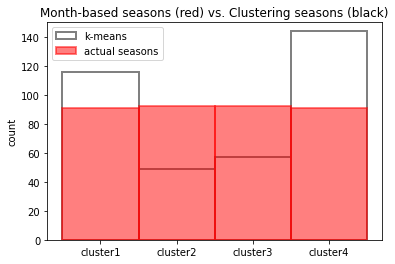

In [ ]:
### Histogram Type #1 - Compare seasons based on month and based on k-means clustering over the entire year

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

#### all data - plot the histogram
h, mids = np.histogram(idx,bins=hist_bins);
plt.hist(idx,bins=mids,facecolor='white',edgecolor="grey",label='k-means',lw=2);
plt.hist(season_idx,bins=mids,facecolor='r',edgecolor="r",label='actual seasons',alpha=0.5,lw=2);
plt.ylabel('count')
plt.ylim(0,150)
plt.xticks(np.arange(1,4+1),labels=['cluster1','cluster2','cluster3','cluster4']);
plt.legend();
plt.title('Month-based seasons (red) vs. Clustering seasons (black)');

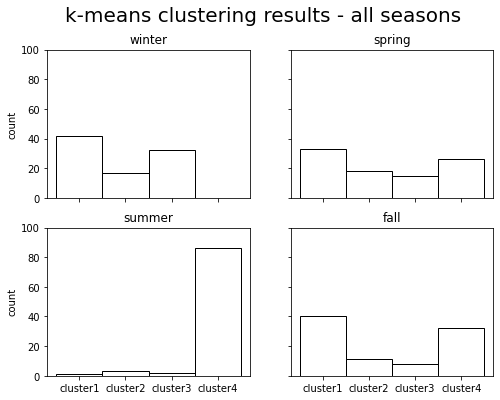

In [ ]:
### Histogram Type #2 - Histograms of seasons based on k-means clustering for each season

## define bins for the histogram
delta= 1                               ## bin size
minbin= 0.5                             ## minimum bin value
maxbin= 5.5                              ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them

## sanity check = plot the histogram of assigned clusters for winter
#h, mids = np.histogram(winter,bins=hist_bins);
#labels4xaxis=['cluster1','cluster2','cluster3','cluster4']
#plt.figure(figsize=(4,4))
#plt.hist(winter,bins=mids,facecolor='w',edgecolor="k");
#plt.xticks(np.arange(1,4+1),labels=labels4xaxis);
#plt.title('Winter');
#plt.show();

### Show all seasons using subplots
### Help with subplots: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

labels4xaxis=['','cluster1','cluster2','cluster3','cluster4']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('k-means clustering results - all seasons',fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(8)

ymax=100
h, mids = np.histogram(winter,bins=hist_bins);
ax1.hist(winter,bins=mids,facecolor='w',edgecolor="k");
ax1.set_title("winter");
ax1.set_ylabel("count");
ax1.set_ylim(0,ymax)
h, mids = np.histogram(spring,bins=hist_bins);
ax2.hist(spring,bins=mids,facecolor='w',edgecolor="k");
ax2.set_title("spring");
ax2.set_ylim(0,ymax)
h, mids = np.histogram(summer,bins=hist_bins);
ax3.hist(summer,bins=mids,facecolor='w',edgecolor="k");
ax3.set_title("summer");
ax3.set_xticklabels(labels4xaxis);
ax3.set_ylabel("count");
ax3.set_ylim(0,ymax)
h, mids = np.histogram(fall,bins=hist_bins);
ax4.hist(fall,bins=mids,facecolor='w',edgecolor="k");
ax4.set_title("fall");
ax4.set_xticklabels(labels4xaxis);
ax4.set_ylim(0,ymax)

for ax in fig.get_axes():
    ax.label_outer()

**STEP 8: Tinker! Once the code above makes sense: Choose your own adventure and start to explore this analysis! Pick One of the Options Below to "tinker". We recommmend you copy the code into a new notebook so that you retain this notebook for easy comparison.**. 

**Option #1: Make a copy of this notebook, and re-run the analysis... but change the code so that you use a different number of clusters (recommend to try 2 clusters, 3 clusters)**. Why do you think the k-means cluster gives different results?  Which number of clusters (i.e., number of seasons identified using k-means clustering) make more sense to you based on your analysis and also your experience living along the front range of Colorado? 

**Option #2: Make a copy of this notebook, and re-run the analysis... but change the code to so that you cluster with less than the original 8 variables**. Which variables (also called "features" in machine learning lingo) are most important for defining the clusters?  What happens if you only cluster based on the wind variables?

**Option #3: Make a copy of this notebook, and re-run the analysis... but change the time of day of the input variable.  Recall this code selected only the data at local noon.** What happens if you run this analysis based on 6 am or 6 pm?  What happens if you run this analysis based on all times of day?

## END OF APPLICATION LAB #3 - Congratulations!! ##